<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/conv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

In [3]:
import torch
torch.cuda.empty_cache()
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Preproccessing on dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)


# Class labels
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


I want see a grid of images of the dataset

ship
.............................................



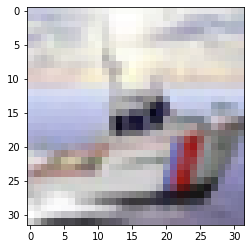

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow(img):
    img = img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(training_loader)
images, labels = dataiter.next()
# print(len(images), len(labels))
print(classes[labels[0]])
print('.............................................\n')
imshow(images[0])




Building The Model
============================

One important behavior of ``torch.nn.Module`` is registering parameters.
If a particular ``Module`` subclass has learning weights, these weights
are expressed as instances of ``torch.nn.Parameter``. The ``Parameter``
class is a subclass of ``torch.Tensor``, with the special behavior that
when they are assigned as attributes of a ``Module``, they are added to
the list of that modules parameters. These parameters may be accessed
through the ``parameters()`` method on the ``Module`` class.

As a simple example, here’s a very simple model with two linear layers
and an activation function. We’ll create an instance of it and ask it to
report on its parameters:


In [64]:


class MyModel(torch.nn.Module):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        # CV
        self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5, padding=2,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(6)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3, padding=1,stride=1)
        self.bn2 = torch.nn.BatchNorm2d(16)

        self.conv3 = torch.nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, padding=1,stride=1)
        self.bn3 = torch.nn.BatchNorm2d(32)

        self.conv4 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2, padding=1,stride=1)
        self.bn4 = torch.nn.BatchNorm2d(64)

        self.pool = torch.nn.MaxPool2d(2, 2)


        # FC
        self.linear1 = torch.nn.Linear(64*16*16, 540)
        self.linear2 = torch.nn.Linear(540, 146)
        self.linear3 = torch.nn.Linear(146, 10)

        # Define proportion or neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)


        # self.softmax = torch.nn.Softmax(dim=10)
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        # print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        # print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool(x)

        # print(x.shape)
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = x.view(-1, 64*16*16)
        # print(x.shape)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)

        output = F.log_softmax(x, dim=1)
        return output

model = MyModel()
model = model.to(device)

print('The model:')
print(model)



The model:
MyModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=16384, out_features=540, bias=True)
  (linear2): Linear(in_features=540, out_features=146, bias=True)
  (linear3): Linear(in_features=146, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace


Loss Function

In [65]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The Training Loop

In [68]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 2000 == 1999:
            last_loss = running_loss / 2000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [69]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

    # running_vloss = 0.0
    # for i, vdata in enumerate(validation_loader):
    #     vinputs, vlabels = vdata
    #     vinputs = vinputs.to(device)
    #     vlabels = vlabels.to(device)
        
    #     voutputs = model(vinputs)
    #     vloss = loss_fn(voutputs, vlabels)
    #     running_vloss += vloss

    # avg_vloss = running_vloss / (i + 1)
    # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    # # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 2000 loss: 1.7845648554712534
  batch 4000 loss: 1.7215364965870976
  batch 6000 loss: 1.668701776444912
  batch 8000 loss: 1.605914630845189
  batch 10000 loss: 1.570474070256576
  batch 12000 loss: 1.5176985340118407
EPOCH 2:
  batch 2000 loss: 1.4249303542468696
  batch 4000 loss: 1.3782675517443568
  batch 6000 loss: 1.327636655319482
  batch 8000 loss: 1.3393033123034983
  batch 10000 loss: 1.3424966180766933
  batch 12000 loss: 1.3257667464502156
EPOCH 3:
  batch 2000 loss: 1.154279073239537
  batch 4000 loss: 1.1603950248309411
  batch 6000 loss: 1.1760362144336105
  batch 8000 loss: 1.1957088267891667
  batch 10000 loss: 1.1716242625387967
  batch 12000 loss: 1.1786023156307637
EPOCH 4:
  batch 2000 loss: 1.0146511968557606
  batch 4000 loss: 0.9993854146116063
  batch 6000 loss: 1.0397532546526054
  batch 8000 loss: 1.034530266199028
  batch 10000 loss: 1.02627633941127
  batch 12000 loss: 1.0289792165916878
EPOCH 5:
  batch 2000 loss: 0.8578490637022478
  bat

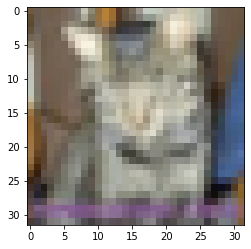

labels:  cat
predicted:  cat


In [73]:
# dataiter = iter(validation_loader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
# images=images.to(device)
# outputs = model(images)
# _, predicted = torch.max(outputs, 1)
# print('predicted : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

import random


index = random.randint(0, 2500 - 1)


for i, data in enumerate(validation_loader):
        # Every data instance is an input + label pair
        if index==i:
          inputs, labels = data
          
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Make predictions for this batch
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          imshow(inputs[0])
          print('labels: ',classes[labels[0]])
          print('predicted: ',classes[predicted[0]])
          break

In [70]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
pred=0
total=0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        pred += (predicted == labels).sum().item()
        total += labels.size(0)

        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * pred / total))

print('--------------------------------------------------------------\n')

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    


Accuracy of the network on the 10000 test images: 73 %
--------------------------------------------------------------

Accuracy of airplane : 72 %
Accuracy of automobile : 88 %
Accuracy of  bird : 58 %
Accuracy of   cat : 55 %
Accuracy of  deer : 70 %
Accuracy of   dog : 67 %
Accuracy of  frog : 79 %
Accuracy of horse : 78 %
Accuracy of  ship : 82 %
Accuracy of truck : 79 %
